# Poisonous Mushrooms: Padrões Frequentes

**Universidade Federal de Ouro Preto**

**PCC142 - Mineração de Dados - 2025/1**

**Prof. Anderson Almeida Ferreira**

**Victor G. Lima**

**Conteúdo**    
- Ambiente    
  - Pacotes e importações    
  - Funções auxiliares    
- Dataset pré-processado    
  - Carregamento do dataset    
- Regras de associação    
  - Discretização de atributos numéricos    
  - Versão binária do dataset    
  - Minerando regras    
  - Regras relacionadas ao objetivo    
    - Cogumelos venenosos    
    - Cogumelos comestíveis    
- Padrões Sequenciais    
  - Estimativa do volume    
  - Definição das sequências    
  - Mineração de padrões sequenciais    
- Referências    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## Ambiente

### Pacotes e importações

In [ ]:
from IPython.display import clear_output

%pip install numpy pandas matplotlib seaborn scikit-learn scipy tqdm mlxtend plotly prefixspan

import os
import warnings
import json
import pickle
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tqdm import tqdm
import plotly.graph_objects as go
from mlxtend.frequent_patterns import apriori, association_rules
from prefixspan import PrefixSpan

random.seed(20250601)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning) 

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.precision", 3)

sns.color_palette("dark")
sns.set_style("dark")

clear_output()

### Funções auxiliares

Funções de plotagem para visualização da distriuição dos dados por atributo no dataset.

In [2]:
def plot_features(features, df, max_categories=15, show_info_box=True):
    if isinstance(features, str):
        features = [features]

    numerical_features = []
    categorical_features = []

    for feature in features:
        if feature in df.columns:
            dtype = df[feature].dropna().dtype
            if pd.api.types.is_numeric_dtype(dtype):
                numerical_features.append(feature)
            else:
                categorical_features.append(feature)

    total_numerical = len(numerical_features)
    total_categorical = len(categorical_features)
    total_rows = (1 if total_numerical > 0 else 0) + (1 if total_categorical > 0 else 0)
    max_cols = max(total_numerical, total_categorical, 1)

    fig, axes = plt.subplots(total_rows, max_cols, figsize=(max_cols * 4, total_rows * 3))
    if total_rows == 1 and max_cols == 1:
        axes = np.array([[axes]])
    elif total_rows == 1:
        axes = np.array([axes])
    elif max_cols == 1:
        axes = np.array([[ax] for ax in axes])
    else:
        axes = axes.reshape((total_rows, max_cols))

    if total_numerical > 0:
        global_x_min = float("inf")
        global_x_max = -float("inf")
        global_y_max = 0
        for feature in numerical_features:
            data = df[feature].dropna()
            hist, bins = np.histogram(data, bins=50)
            global_x_min = min(global_x_min, data.min())
            global_x_max = max(global_x_max, data.max())
            global_y_max = max(global_y_max, hist.max())

        for i, feature in enumerate(numerical_features):
            ax = axes[0, i]
            data = df[feature].dropna()
            ax.hist(data, bins=50, alpha=1.0)
            ax.set_title(f"{feature}")
            ax.set_xlim(global_x_min, global_x_max)
            ax.set_ylim(0, global_y_max * 1.05)
            if i != 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
            if show_info_box:
                ax.text(
                    0.6,
                    0.85,
                    (
                        f"Min: {data.min():.2f}\n"
                        f"Max: {data.max():.2f}\n"
                        f"Mean: {data.mean():.2f}\n"
                        f"Median: {data.median():.2f}\n\n"
                        f"Missing: {df[feature].isna().sum()}"
                    ),
                    transform=ax.transAxes,
                    fontsize=10,
                    verticalalignment="top",
                    horizontalalignment="left",
                    bbox=dict(
                        boxstyle="round,pad=1.0",
                        facecolor="white",
                        edgecolor="black",
                        alpha=0.5,
                    ),
                )

        for j in range(len(numerical_features), max_cols):
            axes[0, j].axis("off")

    if total_categorical > 0:
        row_idx = 1 if total_numerical > 0 else 0
        global_y_max = 0
        for feature in categorical_features:
            value_counts = df[feature].value_counts()
            if len(value_counts) > max_categories:
                top_values = value_counts.head(max_categories - 1)
                other_count = value_counts[max_categories - 1 :].sum()
                top_values["..."] = other_count
                value_counts = top_values
            global_y_max = max(global_y_max, value_counts.max())

        for i, feature in enumerate(categorical_features):
            ax = axes[row_idx, i]
            data = df[feature]
            value_counts = data.value_counts()
            if len(value_counts) > max_categories:
                top_values = value_counts.head(max_categories - 1)
                other_count = value_counts[max_categories - 1 :].sum()
                top_values["..."] = other_count
                value_counts = top_values
            value_counts.plot(kind="bar", ax=ax, color="tab:red", alpha=0.8)
            ax.set_ylim(0, global_y_max * 1.05)
            if i != 0:
                ax.set_yticklabels([])
                ax.set_ylabel("")
            if len(value_counts) > 5:
                plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
            if show_info_box:
                ax.text(
                    0.55,
                    0.8,
                    (
                        f"Classes: {data.nunique()}\n"
                        f"Top: {value_counts.index[0]} ({value_counts.values[0]})\n"
                        f"Missing: {data.isna().sum()}"
                    ),
                    transform=ax.transAxes,
                    fontsize=10,
                    verticalalignment="top",
                    horizontalalignment="left",
                    bbox=dict(
                        boxstyle="round,pad=1.0",
                        facecolor="white",
                        edgecolor="black",
                        alpha=0.5,
                    ),
                )

        for j in range(len(categorical_features), max_cols):
            axes[row_idx, j].axis("off")

    plt.tight_layout()
    plt.show()

## Dataset pré-processado

### Carregamento do dataset

O dataset é carregado pré-processado de acordo com a etapa de pré-processamento. Os valores são mapeados novamente a suas classes descritivas (revertendo as transformações numéricas) para melhor interpretação das associações.

In [3]:
train_df = pd.read_pickle("./data_preprocessed/train_data.pkl")
train_target_df = pd.read_pickle("./data_preprocessed/train_target.pkl")

encoders_map: dict[str, LabelEncoder] = pickle.load(open("./utils/encoders.pkl", "rb"))
scalers_map: dict[str, StandardScaler] = pickle.load(open("./utils/scalers.pkl", "rb"))
feature2class = json.load(open("./utils/feature2class.json"))
classes = json.load(open("./utils/classes.json"))

target = feature2class["poisonous"]
train_df = pd.concat([train_df, train_target_df], axis=1)

loop = tqdm(train_df.keys().tolist(), desc="Loading dataset")
for feature in loop:
    loop.set_postfix(feature=feature)
    encoder_name = feature2class[feature]
    if encoder_name in encoders_map:
        train_df[feature] = pd.Series(encoders_map[encoder_name].inverse_transform(train_df[feature].astype("uint64"))).replace(
            classes[encoder_name]
        )
    elif not pd.api.types.is_numeric_dtype(train_df[feature]):
        train_df[feature] = train_df[feature].astype(bool)
        f = feature2class[feature]
        if f in classes:
            train_df[feature] = train_df[feature].replace({False: "false", True: "true"})
            train_df[feature] = train_df[feature].replace(classes[f]).astype("object")
            train_df = train_df.rename(columns={feature: f})
        else:
            train_df[feature] = train_df[feature].replace({False: "no", True: "yes"}).astype("object")
    else:
        train_df[feature] = pd.Series(scalers_map[feature].inverse_transform(train_df[[feature]]).squeeze())

print("Objtivo:", target, train_df[target].dtype)
print("Shape:", train_df.shape)
train_df.head(10)

Loading dataset: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s, feature=poisonous]          

Objtivo: target object
Shape: (3116945, 16)


,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,ring-type,habitat,season,veil-type,target
0,8.80,flat,smooth,purple,no,adnate,close,white,4.510,15.39,white,none,woods,autumn,partial,edible
1,4.51,convex,shiny,others,no,adnate,close,brown,4.790,6.48,others,others,woods,winter,partial,poisonous
2,6.94,flat,smooth,buff,no,adnexed,close,white,6.850,9.93,brown,none,leaves,winter,partial,edible
3,3.88,flat,scaly,gray,no,sinuate,none,gray,4.160,6.53,white,none,woods,summer,partial,edible
4,5.85,convex,leathery,white,no,decurrent,none,white,3.370,8.36,white,none,grasses,autumn,partial,edible
5,4.30,convex,sticky,brown,no,sinuate,close,brown,5.910,8.20,white,others,woods,autumn,partial,poisonous
6,9.65,spherical,scaly,white,no,free,close,black,7.231,12.69,white,evanescent,grasses,winter,partial,edible
7,4.55,convex,fleshy,red,no,adnate,none,yellow,8.310,9.77,yellow,others,woods,autumn,partial,poisonous
8,7.36,flat,shiny,red,no,adnexed,distant,white,5.770,17.13,white,none,woods,autumn,partial,poisonous
9,6.45,convex,sticky,brown,no,adnate,distant,white,7.130,12.77,red,none,woods,autumn,partial,edible


## Regras de associação

### Discretização de atributos numéricos

Como primeiro passo para a extração de regras de associação, discretizamos os atributos númericos do dataset. Utilizamos `cut` para criar $5$ intervalos iguais como categorias para os atributos numéricos.

Para facilitar a visualização das regras posteriormente, criamos rótulos para estes $5$ intervalos, em ordem crestente de tamanho: `tiny`, `small`, `medium`, `large` e `huge`.

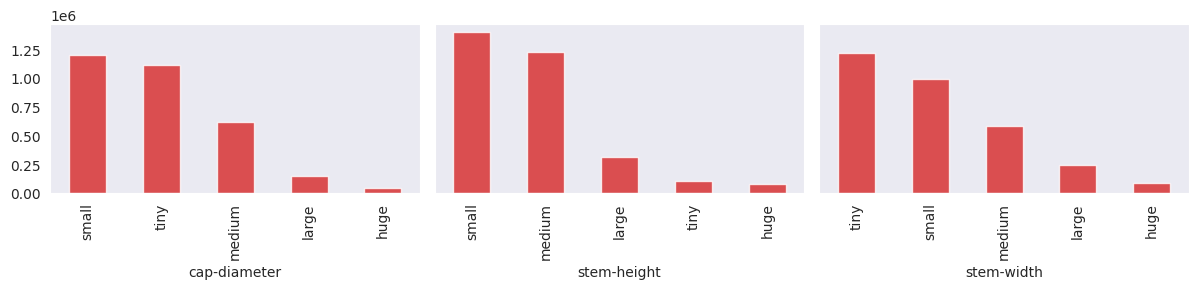

In [4]:
BINS = 5
LABELS = ["tiny", "small", "medium", "large", "huge"]
numerical_feats = train_df.select_dtypes(include="number")

train_df_discrete = train_df.copy()

for feat in numerical_feats:
    train_df_discrete[feat] = pd.cut(train_df_discrete[feat], BINS, labels=LABELS)

num_unique_rows = train_df_discrete.drop_duplicates().shape[0]
num_duplicate_rows = train_df_discrete.duplicated().sum()

# print(f"Instâncias únicas: {num_unique_rows}")
# print(f"Instâncias duplicadas: {num_duplicate_rows}\n")
plot_features(numerical_feats, train_df_discrete, show_info_box=False)

### Versão binária do dataset

Criamos uma versão binária do dataset para aplicar o algoritmo de padrões frequentes utilizando `dummies`.

In [5]:
train_df_binary = pd.get_dummies(train_df_discrete, prefix_sep=": ")
target_itemsets = [f for f in train_df_binary.keys() if "target" in f]

print(f"{train_df_discrete.shape[1]} atributos categóricos -> {train_df_binary.shape[1]} atributos binários")
print("Target items:", target_itemsets)
train_df_binary.head()

16 atributos categóricos -> 104 atributos binários
Target items: ['target: edible', 'target: poisonous']


,cap-diameter: tiny,cap-diameter: small,cap-diameter: medium,cap-diameter: large,cap-diameter: huge,cap-shape: bell,cap-shape: conical,cap-shape: convex,cap-shape: flat,cap-shape: others,cap-shape: spherical,cap-shape: sunken,cap-surface: fibrous,cap-surface: fleshy,cap-surface: grooves,cap-surface: leathery,cap-surface: others,cap-surface: scaly,cap-surface: shiny,cap-surface: silky,cap-surface: smooth,cap-surface: sticky,cap-surface: wrinkled,cap-color: black,cap-color: blue,cap-color: brown,cap-color: buff,cap-color: gray,cap-color: green,cap-color: none,cap-color: others,cap-color: pink,cap-color: purple,cap-color: red,cap-color: white,cap-color: yellow,does-bruise-or-bleed: no,does-bruise-or-bleed: yes,gill-attachment: adnate,gill-attachment: adnexed,gill-attachment: decurrent,gill-attachment: free,gill-attachment: none,gill-attachment: pores,gill-attachment: sinuate,gill-spacing: close,gill-spacing: distant,gill-spacing: none,gill-color: black,gill-color: brown,gill-color: buff,gill-color: gray,gill-color: green,gill-color: none,gill-color: others,gill-color: pink,gill-color: purple,gill-color: red,gill-color: white,gill-color: yellow,stem-height: tiny,stem-height: small,stem-height: medium,stem-height: large,stem-height: huge,stem-width: tiny,stem-width: small,stem-width: medium,stem-width: large,stem-width: huge,stem-color: black,stem-color: blue,stem-color: brown,stem-color: buff,stem-color: gray,stem-color: green,stem-color: none,stem-color: others,stem-color: pink,stem-color: purple,stem-color: red,stem-color: white,stem-color: yellow,ring-type: evanescent,ring-type: flaring,ring-type: grooved,ring-type: large,ring-type: none,ring-type: others,ring-type: pendant,habitat: grasses,habitat: heaths,habitat: leaves,habitat: meadows,habitat: others,habitat: woods,season: autumn,season: spring,season: summer,season: winter,veil-type: partial,veil-type: universal,target: edible,target: poisonous
0,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,True,True,False,False,False,True,False,True,False
1,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,True
2,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,True,False,True,False
3,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,F

Aplicamos um algoritmo para encontrar padrões frequentes (*Apriori*, *FP-Growth* etc). Podemos observar o número de itens frequentes afim do suporte mínimo no intervalo $[0.05, 1.0]$ com $step=0.05$

In [6]:
# calculate frequent item sets
fp_algorithm = apriori  # frequent itemsets algorithm
interval = 1
support_values = [s / 100.0 for s in range(interval, 100 + interval, interval)]

print(f"Obtendo itemsets frequentes com {fp_algorithm.__name__}...")
if os.path.exists(f"./utils/frequent_itemsets_{interval}.pkl"):
    frequent_itemsets = pickle.load(open(f"./utils/frequent_itemsets_{interval}.pkl", "rb"))
else:
    min_support = min(support_values)
    frequent_itemsets = (
        fp_algorithm(train_df_binary, min_support=min_support, use_colnames=True, low_memory=True)
        if fp_algorithm is apriori
        else fp_algorithm(train_df_binary, min_support=min_support, use_colnames=True)
    )
    pickle.dump(frequent_itemsets, open(f"./utils/frequent_itemsets_{interval}.pkl", "wb"))

frequent_counts = [(frequent_itemsets["support"] >= s).sum() for s in support_values]
fig = go.Figure(
    data=[
        go.Bar(
            x=support_values,
            y=frequent_counts,
            text=[str(fc) for fc in frequent_counts],
            textposition="outside",
            marker_color="crimson",
            opacity=0.8,
        )
    ]
)
fig.update_layout(
    title="Number of Itemsets per Minimum Support",
    xaxis_title="Minimum support",
    yaxis_title="Number of itemsets",
    yaxis_type="log",
    template="plotly",
    font=dict(
        family="Arial",
        size=14,
        # color="white",
        weight="bold",
    ),
    yaxis=dict(showticklabels=True, tickformat=","),
    paper_bgcolor="rgba(0, 0, 0, 0)",
    plot_bgcolor="rgba(0, 0, 0, 0)",
)
fig.show()

itemset_lengths = frequent_itemsets["itemsets"].apply(lambda x: len(x))
length_counts = itemset_lengths.value_counts().sort_index()
fig = go.Figure(
    data=[
        go.Bar(
            x=length_counts.index,
            y=length_counts.values,
            text=[str(v) for v in length_counts.values],
            textposition="outside",
            marker_color="royalblue",
            opacity=0.85,
        )
    ]
)
fig.update_layout(
    title="Number of Itemsets by Item Count",
    xaxis_title="Number of items in itemset",
    yaxis_title="Number of itemsets",
    yaxis_type="log",
    template="plotly",
    font=dict(
        family="Arial",
        size=14,
        # color="white",
        weight="bold",
    ),
    uniformtext_minsize=10,
    uniformtext_mode="show",
    xaxis=dict(tickmode="linear", tick0=1, dtick=1),
    yaxis=dict(showticklabels=False, tickformat=","),
    paper_bgcolor="rgba(0, 0, 0, 0)",
    plot_bgcolor="rgba(0, 0, 0, 0)",
)
fig.show()

Obtendo itemsets frequentes com apriori...


### Minerando regras

Observando os *itemsets* com suporte mínimo $> 0.50$, verificamos as classes de atributos mais frequentes no dataset. Iremos filtrar esses items dos consequentes na mineração de regras de associação, com exceção de *itemsets* do atrbuto *target*. 

In [7]:
exclude_itemsets = (
    frequent_itemsets[(frequent_itemsets["support"] > 0.5) & (frequent_itemsets["itemsets"].apply(len) == 1)]["itemsets"]
    .apply(lambda x: next(iter(x)))
    .tolist()
)
exclude_itemsets = [i for i in exclude_itemsets if i not in target_itemsets]

exclude_itemsets

['does-bruise-or-bleed: no',
 'ring-type: none',
 'habitat: woods',
 'veil-type: partial']

Com os *itemsets* obtidos pelo algoritmo, junto aos seus suportes mínimos, criamos suas regras de associação e calculamos os valores para suporte, confiança, *lift* e *conviction*.  

Inicialmente, utilizamos os sequintes parâmetros para minerar as regras de associação:

`rule_support` $\geq 0.05$

`rule_confidence` $\geq 0.70$

`rule_lift` $\geq 1.00$

`rule_conviction` $\geq 1.00$

In [8]:
RULES_COLUMNS = [
    "antecedents",
    "consequents",
    "antecedent support",
    "consequent support",
    "support",
    "confidence",
    "lift",
    "conviction",
]

RULE_SUPPORT = 0.01
RULE_CONFIDENCE = 0.7
RULE_LIFT = 1.0
RULE_CONVICTION = 1.0

metric = "confidence"
min_threshold = RULE_CONFIDENCE
rules = association_rules(
    frequent_itemsets[(~frequent_itemsets["itemsets"].apply(lambda x: any(item in exclude_itemsets for item in x)))],
    metric=metric,
    min_threshold=min_threshold,
)
rules = (
    rules[(rules["support"] >= RULE_SUPPORT) & (rules["lift"] >= RULE_LIFT) & (rules["conviction"] >= RULE_CONVICTION)]
    .sort_values(by=["lift"], ascending=False)
    .reset_index(drop=True)[RULES_COLUMNS]
)
grouped_rules = rules.groupby("consequents")

print("Número de regras de associação (ordenadas por 'lift'):", len(rules))
print("Regras agrupadas por 'consequents' (número de grupos):", len(grouped_rules))
rules.head(10)

Número de regras de associação (ordenadas por 'lift'): 66566
Regras agrupadas por 'consequents' (número de grupos): 1460


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,conviction
0,"(gill-attachment: free, gill-spacing: close, target: edible, cap-color: white)","(ring-type: evanescent, stem-width: small, stem-color: white)",0.011,0.015,0.010,0.953,65.673,21.177
1,"(ring-type: evanescent, stem-color: white, target: edible)","(gill-attachment: free, stem-width: small, gill-spacing: close, cap-color: white)",0.011,0.016,0.010,0.928,59.264,13.720
2,"(cap-surface: scaly, stem-width: tiny, gill-attachment: none)","(cap-color: brown, cap-diameter: tiny, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)",0.017,0.012,0.012,0.726,59.112,3.603
3,"(cap-color: brown, cap-diameter: tiny, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)","(cap-surface: scaly, stem-width: tiny, gill-attachment: none)",0.012,0.017,0.012,0.986,59.112,71.550
4,"(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-width: tiny, stem-color: white)","(cap-surface: scaly, cap-diameter: tiny, gill-attachment: none)",0.013,0.016,0.012,0.944,58.826,17.455
5,"(cap-surface: scaly, cap-diameter: tiny, gill-attachment: none)","(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-width: tiny, stem-color: white)",0.016,0.013,0.012,0.755,58.826,4.029
6,"(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)","(cap-surface: scaly, stem-width: tiny, gill-attachment: none)",0.013,0.017,0.013,0.981,58.810,52.352
7,"(cap-surface: scaly, stem-width: tiny, gill-attachment: none)","(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)",0.017,0.013,0.013,0.759,58.810,4.103
8,"(cap-surface: scaly, stem-width: tiny, cap-diameter: tiny, gill-attachment: none)","(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)",0.016,0.013,0.012,0.758,58.687,4.076
9,"(cap-color: brown, cap-shape: bell, stem-height: medium, gill-spacing: close, stem-color: white)","(cap-surface: scaly, stem-width: tiny, cap-diameter: tiny, gill-attachment: none)",0.013,0.016,0.012,0.938,58.687,15.830


### Regras relacionadas ao objetivo

Iremos verificar regras que possuem em seus consequentes itens do atributo objetivo (*target*): `target: edible` ou `target: poisonous`.

Dado as métricas calculadas sobre a regra $A \rightarrow B$.


\begin{aligned}
\text{support} \quad sp & = sp(A \cap B) \\
\text{confidence} \quad cf & = \frac{sp(A \rightarrow B)}{sp(A)} \\
\text{lift} \quad lf & = \frac{c(A \rightarrow B)}{sp(B)} \\
\text{conviction} \quad cv & = \frac{sp(A) \cdot sp(\lnot B)}{sp(A \cap \lnot B)}
\end{aligned}

#### Cogumelos venenosos

`support` $\geq 0.025$

`confidence` $\geq 0.900$

`lift` $\geq 1.000$

`conviction` $\geq 1.000$

In [9]:
rules_with_poisonous = rules[
    (rules["consequents"].apply(len) == 1)
    & (rules["consequents"].apply(lambda x: next(iter(x)) == "target: poisonous"))
    & (rules["support"] >= 0.025)
    & (rules["confidence"] >= 0.9)
    & (rules["lift"] >= 1.0)
    & (rules["conviction"] >= 1.0)
].sort_values(by="confidence", ascending=False)

print("Número de regras encontradas:", len(rules_with_poisonous))
rules_with_poisonous.head(10)

Número de regras encontradas: 76


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,conviction
56819,"(cap-color: brown, gill-spacing: none, stem-color: brown, stem-height: small, gill-color: brown, stem-width: tiny)",(target: poisonous),0.026,0.547,0.026,0.997,1.822,158.347
56891,"(cap-color: brown, gill-spacing: none, stem-color: brown, gill-color: brown, stem-width: tiny)",(target: poisonous),0.027,0.547,0.027,0.997,1.822,141.403
56928,"(gill-spacing: close, ring-type: others)",(target: poisonous),0.027,0.547,0.026,0.997,1.821,132.821
56946,"(gill-spacing: none, stem-color: brown, gill-color: brown, stem-height: small, stem-width: tiny)",(target: poisonous),0.029,0.547,0.028,0.996,1.821,128.251
57007,"(gill-spacing: none, gill-color: brown, stem-width: tiny, stem-color: brown)",(target: poisonous),0.031,0.547,0.031,0.996,1.821,118.323
57192,"(cap-color: brown, gill-spacing: none, gill-color: brown, stem-height: small, stem-width: tiny)",(target: poisonous),0.026,0.547,0.026,0.995,1.818,87.225
57208,"(cap-color: brown, gill-spacing: none, cap-diameter: tiny, gill-color: brown, stem-width: tiny)",(target: poisonous),0.027,0.547,0.027,0.995,1.818,85.127
57290,"(gill-spacing: none, cap-diameter: tiny, gill-color: brown, stem-width: tiny)",(target: poisonous),0.032,0.547,0.032,0.994,1.817,74.739
57296,"(gill-spacing: none, gill-color: brown, stem-width: tiny, stem-height: small)",(target: poisonous),0.031,0.547,0.031,0.994,1.816,73.926
57315,"(cap-color: brown, gill-spacing: none, gill-color: brown, stem-width: tiny)",(target: poisonous),0.032,0.547,0.032,0.994,1.816,72.374


Seja $A \rightarrow B =$ $\{$`cap-color: brown`, `gill-color: brown`, `gill-spacing: none`, `stem-color: brown`, `stem-height: small`, `stem-width: tiny` $\}$ $\rightarrow$	$\{$`target: poisonous`$\}$

Os valores de *antecedent support* e *consequent support* nos mostram a porcentagem da ocorrência dos *itemsets* $A$ e $B$, respectivamente, no dataset.

Um suporte de $0.026$, significa que essa regra está presente em aproximadamente $2,6\%$ das instâncias, com uma confiança de $0.997$, ou seja, mais de $99\%$ de todas as instâncias onde $A$ ocorre, os cogumelos são venenosos.

A elevação (*lift*) de $1.822$ nos indica a proporção em que a presença de $A$ aumenta a chance do cogumelo ser venenoso em aproximadamente $82\%$ em relação a uma ocorrência aleatória, onde $A$ não influencia o cogumelo a ser venenoso.

A convicção (*conviction*) de $158.347$ revela que, se essa regra fosse falsa, ou seja, o cogumelo não fosse venenoso mesmo tendo essas características, isso aconteceria aproximadamente $158$ vezes menos frequentemente do que se não houvesse nenhuma relação entre o antecedente $A$ e ser venenoso (consequente).

Concluindo:

 - A regra é relativamente rara (com baixo suporte), em relação ao total de instâncias.
 - É altamente confiável quando ocorre, com $cf \geq 99\%$.
 - Com $lf > 1$, confirmamos uma associação positiva entre $A$ e o cogumelo ser venenoso.
 - Com o alto valor de $cv$, podemos dizer que as exceções à regra são extremamente raras e que o antecedente $A$ é um bom indicador preditivo de que o cogumelo será venenoso.

In [10]:
print(sorted(rules_with_poisonous.loc[56819, "antecedents"]), "->", list(rules_with_poisonous.loc[56819, "consequents"]))
pd.DataFrame(rules_with_poisonous.loc[56819])

['cap-color: brown', 'gill-color: brown', 'gill-spacing: none', 'stem-color: brown', 'stem-height: small', 'stem-width: tiny'] -> ['target: poisonous']


,56819
antecedents,"(cap-color: brown, gill-spacing: none, stem-color: brown, stem-height: small, gill-color: brown, stem-width: tiny)"
consequents,(target: poisonous)
antecedent support,0.026
consequent support,0.547
support,0.026
confidence,0.997
lift,1.822
conviction,158.347


#### Cogumelos comestíveis

`support` $\geq 0.015$

`confidence` $\geq 0.995$

`lift` $\geq 1.000$

`conviction` $\geq 1.000$

In [11]:
rules_with_edible = rules[
    (rules["consequents"].apply(len) == 1)
    & rules["consequents"].apply(lambda x: next(iter(x)) == "target: edible")
    & (rules["support"] >= 0.015)
    & (rules["confidence"] >= 0.995)
    & (rules["lift"] >= 1.00)
    & (rules["conviction"] >= 1.00)
].sort_values(by="confidence", ascending=False)

print("Número de regras encontradas:", len(rules_with_edible))
rules_with_edible.head(10)

Número de regras encontradas: 15


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,conviction
46454,"(gill-attachment: free, stem-width: medium, stem-height: large, stem-color: white, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,129.857
46455,"(gill-spacing: none, gill-attachment: free, stem-width: medium, stem-height: large, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,129.391
46456,"(stem-height: large, gill-attachment: free, stem-width: medium, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,128.234
46460,"(gill-spacing: none, gill-attachment: free, stem-height: large, stem-color: white, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,126.771
46463,"(gill-attachment: free, stem-color: white, stem-height: large, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,126.279
46468,"(gill-spacing: none, gill-attachment: free, stem-height: large, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.199,125.231
46474,"(gill-attachment: free, stem-height: large, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.996,2.198,124.158
46495,"(cap-color: brown, gill-spacing: none, gill-attachment: free, stem-width: medium, stem-color: white, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.995,2.198,118.763
46496,"(cap-color: brown, gill-spacing: none, gill-attachment: free, stem-width: medium, does-bruise-or-bleed: yes)",(target: edible),0.016,0.453,0.015,0.995,2.198,118.562
46497,"(cap-color: brown, gill-attachment: free, stem-width: medium, stem-color: white, does-bruise-or-bleed: yes)",(target: edible),0.015,0.453,0.015,0.995,2.198,118.378


Seja $A \rightarrow B =$ $\{$`does-bruise-or-bleed: yes`, `gill-attachment: free`, `stem-color: white`, `stem-height: large`, `stem-width: medium`$\}$ $\rightarrow$	$\{$`target: edible`$\}$

Os valores de *antecedent support* e *consequent support* nos mostram a porcentagem da ocorrência dos *itemsets* $A$ e $B$, respectivamente, no dataset.

Um suporte de $0.015$, significa que essa regra está presente em aproximadamente $1,5\%$ das instâncias, com uma confiança de $0.996$, ou seja, mais de $99\%$ de todas as instâncias onde $A$ ocorre, os cogumelos são comestíveis.

A elevação (*lift*) de $2.199$ nos indica a proporção em que a presença de $A$ aumenta a chance do cogumelo ser comestível em aproximadamente $120\%$ em relação a uma ocorrência aleatória, onde $A$ não influencia o cogumelo a ser comestível.

A convicção (*conviction*) de $129.857$ revela que, se essa regra fosse falsa, ou seja, o cogumelo não fosse comestível mesmo tendo essas características, isso aconteceria aproximadamente $130$ vezes menos frequentemente do que se não houvesse nenhuma relação entre o antecedente $A$ e ser comestível (consequente).

Concluindo:

 - A regra é relativamente rara (com baixo suporte), em relação ao total de instâncias.
 - É altamente confiável quando ocorre, com $cf \geq 99\%$.
 - Com $lf > 1$, confirmamos uma associação positiva entre $A$ e o cogumelo ser comestível.
 - Com o alto valor de $cv$, podemos dizer que as exceções à regra são extremamente raras e que o antecedente $A$ é um bom indicador preditivo de que o cogumelo será comestível.
 - Também é importante notar a importância do alto valor para confiança na predição se um cogumelo é comestível.

In [12]:
print(sorted(rules_with_edible.loc[46454, "antecedents"]), "->", list(rules_with_edible.loc[46454, "consequents"]))
pd.DataFrame(rules_with_edible.loc[46454])

['does-bruise-or-bleed: yes', 'gill-attachment: free', 'stem-color: white', 'stem-height: large', 'stem-width: medium'] -> ['target: edible']


,46454
antecedents,"(gill-attachment: free, stem-width: medium, stem-height: large, stem-color: white, does-bruise-or-bleed: yes)"
consequents,(target: edible)
antecedent support,0.015
consequent support,0.453
support,0.015
confidence,0.996
lift,2.199
conviction,129.857


## Padrões Sequenciais

Para criar uma sequência com o dataset, utilizamos características de tamanho dos cogumelos. Como temos três catacterísticas que nos dão uma ideia da grandeza do cogumelo em um espaço tridimensional, calculamos seu volume estimado a partir dessas grandezas.

### Estimativa do volume

Calculamos uma estimativa do volume dos cogumelos com base nos valores de `cap-diameter`, `stem-height` e `stem-width`, e criamos um novo atributo `volume`.


In [13]:
def estimate_mushroom_volume(cap_diameter_cm, stem_height_cm, stem_width_mm):
    # convert stem width from mm to cm and calculate radius
    stem_radius_cm = stem_width_mm / 2 * 10
    # cap is a hemisphere: V = (2/3) * π * r³
    cap_radius_cm = cap_diameter_cm / 2
    cap_volume = (2 / 3) * np.pi * (cap_radius_cm**3)
    # stem is a cylinder: V = π * r² * h
    stem_volume = np.pi * (stem_radius_cm**2) * stem_height_cm
    return cap_volume + stem_volume


if os.path.exists("./utils/train_df_volume.pkl"):
    train_df_volume = pickle.load(open("./utils/train_df_volume.pkl", "rb"))
else:
    train_df_volume = train_df.copy()
    train_df_volume.head()
    train_df_volume["volume"] = train_df.apply(
        lambda row: estimate_mushroom_volume(row["cap-diameter"], row["stem-height"], row["stem-width"]), axis=1
    )
    pickle.dump(train_df_volume, open("./utils/train_df_volume.pkl", "wb"))

train_df_volume.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,ring-type,habitat,season,veil-type,target,volume
0,8.80,flat,smooth,purple,no,adnate,close,white,4.51,15.39,white,none,woods,autumn,partial,edible,186.799
1,4.51,convex,shiny,others,no,adnate,close,brown,4.79,6.48,others,others,woods,winter,partial,poisonous,25.596
2,6.94,flat,smooth,buff,no,adnexed,close,white,6.85,9.93,brown,none,leaves,winter,partial,edible,92.813
3,3.88,flat,scaly,gray,no,sinuate,none,gray,4.16,6.53,white,none,woods,summer,partial,edible,16.685
4,5.85,convex,leathery,white,no,decurrent,none,white,3.37,8.36,white,none,grasses,autumn,partial,edible,54.262


### Definição das sequências

Para este experimento, vamos observar a presença de padrões de sequência a partir das características do formato do chápeu do cogumelo, como `cap-surface` e `cap-shape`. Para isso iremos agrupar os cogumelos com as demais características de formato, e ordenar por volume.

In [14]:
if os.path.exists("./utils/train_df_seq.pkl"):
    with open("./utils/train_df_seq.pkl", "rb") as f:
        train_df_seq = pickle.load(f)
else:
    train_df_seq = train_df_volume.copy()

    series_feature = "volume"
    target_features = ["cap-surface", "cap-shape"]
    group_features = [
        "gill-spacing",
        "gill-attachment",
        "ring-type",
        "veil-type",
    ]

    # Criação do ID
    train_df_seq["id"] = (
        train_df_seq[group_features]
        .astype(str)
        .agg(lambda x: "; ".join(f"{col}: {val}" for col, val in zip(group_features, x)), axis=1)
    )

    # Criação do target
    train_df_seq["target"] = (
        train_df_seq[target_features]
        .astype(str)
        .agg(lambda x: "; ".join(f"{col}: {val}" for col, val in zip(target_features, x)), axis=1)
    )

    # Remover instâncias com "others" no target
    train_df_seq = train_df_seq[~train_df_seq["target"].str.contains("others")]

    # Adiciona a série
    train_df_seq["series"] = train_df_seq[series_feature]

    # Seleciona colunas e remove duplicatas
    train_df_seq = train_df_seq[["id", "target", "series"]].drop_duplicates()

    # Salvar no pickle
    with open("./utils/train_df_seq.pkl", "wb") as f:
        pickle.dump(train_df_seq, f)

# Informações de saída
print("Número de instâncias:", len(train_df_seq))
print("Número de IDs:", train_df_seq["id"].nunique())
train_df_seq[["id", "target", "series"]].head()

Número de instâncias: 2178129
Número de IDs: 2377


,id,target,series
0,gill-spacing: close; gill-attachment: adnate; season: autumn; habitat: woods; ring-type: none; veil-type: partial; target: edible; does-bruise-or-bleed: no,cap-surface: smooth; cap-shape: flat,186.799
1,gill-spacing: close; gill-attachment: adnate; season: winter; habitat: woods; ring-type: others; veil-type: partial; target: poisonous; does-bruise-or-bleed: no,cap-surface: shiny; cap-shape: convex,25.596
2,gill-spacing: close; gill-attachment: adnexed; season: winter; habitat: leaves; ring-type: none; veil-type: partial; target: edible; does-bruise-or-bleed: no,cap-surface: smooth; cap-shape: flat,92.813
3,gill-spacing: none; gill-attachment: sinuate; season: summer; habitat: woods; ring-type: none; veil-type: partial; target: edible; does-bruise-or-bleed: no,cap-surface: scaly; cap-shape: flat,16.685
4,gill-spacing: none; gill-attachment: decurrent; season: autumn; habitat: grasses; ring-type: none; veil-type: partial; target: edible; does-bruise-or-bleed: no,cap-surface: leathery; cap-shape: convex,54.262


Após o agrupamento, criamos as sequencias que serão utilizadas para a mineração de padrões de sequência.

In [15]:
def truncate_sequence(seq, n, m, max_attempts=100):
    if len(seq) < n:
        return [seq]
    results = set()
    attempts = 0
    while len(results) < m and attempts < max_attempts:
        indices = tuple(sorted(random.sample(range(len(seq)), n)))
        results.add(indices)
        attempts += 1
    return [[seq[i] for i in idx] for idx in results]


sequences = (
    train_df_seq.sort_values(by=["id", "series"])
    .groupby("id")["target"]
    .apply(list)
    .apply(lambda seq: truncate_sequence(seq, 100, 2))
    .tolist()
)

sequences = [item for sublist in sequences for item in sublist]

len(sequences)

2833

### Mineração de padrões sequenciais

Utilizamos o algoritmo `PrefixSpan` para minerar os padrões sequenciais, utilizando um suporte mínimo de $0.05$.

In [16]:
ps = PrefixSpan(sequences)

frequent_sequences = ps.frequent(int(0.05 * len(sequences)))
frequent_sequences = sorted(frequent_sequences, key=lambda x: x[0], reverse=True)
frequent_sequences_df = pd.DataFrame(frequent_sequences, columns=["support", "pattern"])
frequent_sequences_df["support"] = frequent_sequences_df["support"] / len(sequences)


def no_consecutive_repeats(pattern):
    if len(pattern) < 2:
        return True
    if pattern[0] == pattern[1]:
        return False
    return no_consecutive_repeats(pattern[1:])


most_frequent_sequences_df = frequent_sequences_df[
    (frequent_sequences_df["pattern"].apply(len) >= 2)
    & (frequent_sequences_df["pattern"].apply(lambda x: len(set(x))) >= 3)
    & (frequent_sequences_df["pattern"].apply(no_consecutive_repeats))
]

most_frequent_sequences_df.head(10)

,support,pattern
737,0.070,"[cap-surface: shiny; cap-shape: convex, cap-surface: sticky; cap-shape: convex, cap-surface: smooth; cap-shape: convex]"
762,0.070,"[cap-surface: scaly; cap-shape: convex, cap-surface: smooth; cap-shape: convex, cap-surface: smooth; cap-shape: flat]"
838,0.069,"[cap-surface: scaly; cap-shape: flat, cap-surface: smooth; cap-shape: convex, cap-surface: smooth; cap-shape: flat]"
909,0.068,"[cap-surface: sticky; cap-shape: convex, cap-surface: shiny; cap-shape: convex, cap-surface: smooth; cap-shape: convex]"
1246,0.066,"[cap-surface: smooth; cap-shape: convex, cap-surface: scaly; cap-shape: convex, cap-surface: smooth; cap-shape: flat]"
1332,0.065,"[cap-surface: smooth; cap-shape: convex, cap-surface: sticky; cap-shape: convex, cap-surface: shiny; cap-shape: convex]"
1507,0.065,"[cap-surface: scaly; cap-shape: flat, cap-surface: smooth; cap-shape: flat, cap-surface: smooth; cap-shape: convex]"
1677,0.064,"[cap-surface: scaly; cap-shape: convex, cap-surface: smooth; cap-shape: flat, cap-surface: smooth; cap-shape: convex]"
1762,0.063,"[cap-surface: sticky; cap-shape: convex, cap-surface: smooth; cap-shape: convex, cap-surface: shiny; cap-shape: convex]"
2075,0.062,"[cap-surface: shiny; cap-shape: convex, cap-surface: smooth; cap-shape: convex, cap-surface: sticky; cap-shape: convex]"


Podemos observar com as padrões sequenciais minerados, que os cogumelos tendem a possuir uma superfície do chapeu (`cap-surface`) mais lisa (`smooth`) conforme seu tamanho aumenta. Já em relação ao formato do chapéu (`cap-shape`), a tendência é seu formato convexo (`convex`) se tornar mais achatado (`flat`).

In [17]:
def print_patterns_from_df(df):
    for idx, row in df.iterrows():
        print(f"Support: {row['support']:.3f}")
        for i, item in enumerate(row["pattern"], 1):
            parts = [part.strip() for part in item.split(";")]
            formatted = "\t|\t".join(parts)
            print(formatted)
        print()


print_patterns_from_df(most_frequent_sequences_df)

Support: 0.070
cap-surface: shiny	|	cap-shape: convex
cap-surface: sticky	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: convex

Support: 0.070
cap-surface: scaly	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: flat

Support: 0.069
cap-surface: scaly	|	cap-shape: flat
cap-surface: smooth	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: flat

Support: 0.068
cap-surface: sticky	|	cap-shape: convex
cap-surface: shiny	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: convex

Support: 0.066
cap-surface: smooth	|	cap-shape: convex
cap-surface: scaly	|	cap-shape: convex
cap-surface: smooth	|	cap-shape: flat

Support: 0.065
cap-surface: smooth	|	cap-shape: convex
cap-surface: sticky	|	cap-shape: convex
cap-surface: shiny	|	cap-shape: convex

Support: 0.065
cap-surface: scaly	|	cap-shape: flat
cap-surface: smooth	|	cap-shape: flat
cap-surface: smooth	|	cap-shape: convex

Support: 0.064
cap-surface: scaly	|	cap-shape: convex
cap-surface: 

## Referências

Reade W., Chow A. (2024). Kaggle. Binary Prediction of Poisonous Mushrooms. https://kaggle.com/competitions/playground-series-s4e8.

Mushroom [Dataset]. (1981). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.

Wagner, D., Heider, D., & Hattab, G. (2021). Secondary Mushroom [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5FP5Q.